<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель:** обучить модель, которая будет классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

**Примечание:** построить модель со значением метрики качества *F1* не меньше 0.75. 

**Данные:**
- text - текст комментария;
- toxic - целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from tqdm.notebook import tqdm
tqdm.pandas()

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
RANDOM_STATE = 12345

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\borod\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\borod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\borod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\borod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
try:
    data =  pd.read_csv('C:/Users/borod/OneDrive/Рабочий стол/DS/project12_comments/toxic_comments.csv')
except:
    data =  pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.sample(5)

,Unnamed: 0,text,toxic
9907,9920,"""\n\n """"The Late"""""""" \n\nI appreciate you givi...",0
29366,29405,"Though, having researched it a bit more, I'd l...",0
153713,153870,FREE MYANMAR!!! STOP THE MILITARY REGIME!!!! P...,0
155014,155171,"""\n\nI just recall that De728631 has been cons...",0
76482,76558,It appears you can expect lame shit like that ...,1


Удалим ненужный столбец `Unnamed: 0`.

In [4]:
data = data.drop('Unnamed: 0', axis = 1)

Пропусков и дубликатов не наблюдается.

In [5]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [6]:
data.duplicated().sum()

0

Посмотрим на распределение в целевом признаке `toxic`. Видим явный дисбаланс классов. В дальнейшем в train_test_split будем применять stratify для выравнивания.

<AxesSubplot:title={'center':'toxic'}, xlabel='toxic', ylabel='count'>

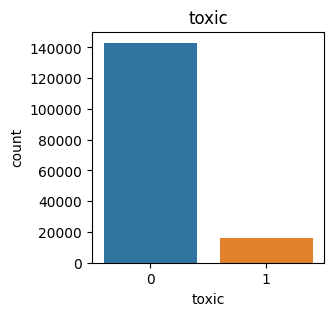

In [7]:
figure, ax = plt.subplots(figsize=(3,3))
ax.set_title('toxic')
sns.countplot(x ='toxic', data = data,ax=ax)

Введем ряд функций, которые:
- a) `pos_tagger` -  функция для лемматизации каждого слова его POS-тегом;
- b) `cleaner` - очистка комментария с помощью регулярных выражений от символов и удаление стоп-слов;
- c) `all_clean` - лемматизация WordNet с POS-тегами.

In [8]:
lemmatizer = WordNetLemmatizer()
pattern = r'[^a-z]'

#определяем функцию для лемматизации каждого слова его POS-тегом
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

#чистим от символом и стоп-слов
def cleaner(comment):
    text = re.sub(pattern, ' ', comment.lower()).split()
    for word in text:
        if word and word in stop_words:
            text.remove(word)
    return " ".join(text)

#лемматизируем
def all_clean(comment):
    sentence = cleaner(comment)
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #если нет доступного тега, добавь токен как есть
            lemmatized_sentence.append(word)
        else:       
            # иначе используй тег, чтобы лемматизировать токен
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [9]:
corpus = data['text'].progress_apply(cleaner)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
corpus

0         explanation edits made my username hardcore me...
1         aww matches background colour m seemingly stuc...
2         hey man m really trying edit war s that guy co...
3         t make real suggestions improvement wondered s...
4                        sir my hero chance remember page s
                                ...                        
159287    for second time asking your view completely co...
159288    should ashamed yourself is horrible thing put ...
159289    spitzer umm theres actual article prostitution...
159290    looks like it was actually who put speedy have...
159291    really t think understand i came and idea bad ...
Name: text, Length: 159292, dtype: object

Разделим выборку на обучающую и тестовую, добавим stratify.

In [14]:
features_train,features_test,target_train,target_test = train_test_split(corpus,data['toxic'],test_size=0.2,
                                                                          random_state=RANDOM_STATE,
                                                                          stratify = data['toxic'])

Вычислим TF-IDF для текстов обучающей и тестовой выборках.

In [15]:
print('train', features_train.shape,target_train.shape)
print('test', features_test.shape, target_test.shape)

train (127433,) (127433,)
test (31859,) (31859,)


## Обучение

Будем пользоваться следующими моделями с применением пайплайна:

- LogisticRegression;
- RandomForestClassifier;
- LGBMClassifier.

Введем функцию `learn`, которая будет проводить поиск наилучших гиперпараметров. В TfidVectorizer возьмем ngram_range = (1,1) для более быстрого обучения, также ограничим пространство признаков с помощью min_df = 0.0001. 

In [16]:
def learn(model,parameters):
    pipe = Pipeline([
        ('vct', TfidfVectorizer(min_df = 0.0001, ngram_range=(1,1))),
        ('model', model)])
    grid_cv = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=parameters,scoring ='f1', verbose=False)
    grid_cv.fit(features_train,target_train)
    print('Лучшая  метрика:', grid_cv.best_score_)
    print('Лучшие параметры:', grid_cv.best_params_)
    return grid_cv

`LogisticRegression`

In [17]:
%%time
lr_param =  {'model__solver': ['liblinear'], 'model__penalty': ['l1', 'l2']}
lr = learn(LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'), lr_param)

Лучшая  метрика: 0.7420422887033785
Лучшие параметры: {'model__penalty': 'l1', 'model__solver': 'liblinear'}
CPU times: total: 27.2 s
Wall time: 6min 26s


`RandomForest`

In [18]:
%%time
rf_param = {'model__max_depth':[80,100], 'model__n_estimators': [200,300]}
rf = learn(RandomForestClassifier(random_state=RANDOM_STATE), rf_param)

Лучшая  метрика: 0.6379485666410522
Лучшие параметры: {'model__max_depth': 100, 'model__n_estimators': 300}
CPU times: total: 16min 17s
Wall time: 9h 5min 24s


`LGBM`

In [30]:
%%time
lgbm_param = {'model__learning_rate': [0.1,0.2], 'model__max_depth': [30, 40]}
lgbm =  learn(LGBMClassifier(random_state = RANDOM_STATE), lgbm_param)

Лучшая  метрика: 0.7616825550308327
Лучшие параметры: {'model__learning_rate': 0.2, 'model__max_depth': 30}
CPU times: total: 3min 28s
Wall time: 43min 51s


**Вывод**: как видим, лучшая метрика получилась на модели LGBM, её и будем брать для тестовой.

## Выводы

Итак, на начальном этапе была проведена очистка комментариев от стоп-слов, символов, также лемматизация.

Для обучения выбраны модели логистической регрессии, случайного леса и градиентного бустинга. На тренировочной выборке лучшую метрику показала модель LGBM, поэтому прогоним её на тестовой выборке.

In [31]:
result = f1_score(target_test, lgbm.predict(features_test))
print('Метрика на тестовой выборке для модели LGBM: ',result)

Метрика на тестовой выборке для модели LGBM:  0.7659724673491


Полученное значение F1-меры = **0.7659724673491** удовлетворяет условиям.